# CODIGOS PARA OBTENER EL LIKELIHOOD Y EL POSTERIOR DE UN CONJUNTO DE DATOS

In [1]:
# Importamos las librerias que se utilizaran
import numpy as np
import emcee
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import random
import scipy.optimize as op
import corner
import matplotlib
plt.style.use('classic')

Creamos un conjunto de datos que corresponden a una linea con pendiente 'a' y ordenada al origen 'b'.

In [2]:
a = 3
b = 2
n = 15
xor = np.linspace(0,2,15)
yor = a*xor + b

Definimos una funcion llamada linea que corresponde al modelo a evaluar en este ejercicio

In [3]:
def line(x, m, b):
    return(m*x + b)

Graficamos el conjunto de datos generado y el conjunto de datos obtenido con el modelo.

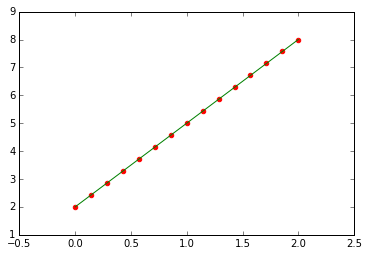

In [4]:
# Graficamos un conjuntp de datos
plt.plot(xor,line(xor,3,2), color='green')
plt.scatter(xor, yor, color='red')

Definimos una desviacion estandar y un valor llamado 'error' para similar un conjunto de datos obtenido en algun experimento.

In [36]:
sigma = 0.2
error = np.random.uniform(low=-sigma, high=sigma, size=15)

Sumamos el conjunto de valores de 'error' para obtener el conjunto de datos simulado de alguna medicion en el experimento

In [37]:
ydat = yor + error
data = ydat

In [38]:
error

array([-0.10553457, -0.03769414,  0.0967358 ,  0.04419236, -0.07095326,
       -0.04286152,  0.01727802,  0.04079359, -0.09593914,  0.14801707,
        0.06532578,  0.1307577 , -0.10588714, -0.14413277, -0.18673506])

Graficamos el conjunto original y el conjunto de datos simulado

<function matplotlib.pyplot.show(*args, **kw)>

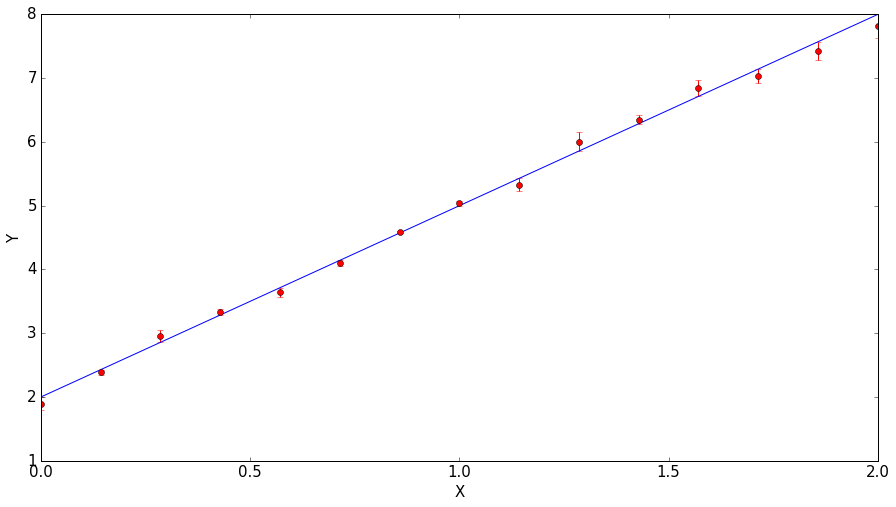

In [104]:
fig, ax = plt.subplots()
ax.errorbar(xor, ydat, yerr=error,fmt='o', c='red')
plt.plot(xor, yor, c='blue', label='ORIGINAL')
plt.xlabel('X')
plt.ylabel('Y')
plt.show

Se definen las siguientes funciones para obtener el logaritmo natural de likelihood, evaluar una cadena de Markov, obtener el prior y el logaritmo de posterior. 

In [8]:
# Se define la funcion quemar para el burning de datos. Se ingresa el porcentaje a quemar
def quemar(x, porcentaje):
    p = porcentaje/100
    x2 = x[int(len(x)*p):]
    return x2

def quemar2(x, y, porcentaje):
    p = porcentaje/100
    x2 = x[int(len(x)*p):]
    y2 = y[int(len(y)*p):]
    return x2,y2

# Se define una funcion para determinar la media de los datos quemados

def quemaymedia(x, porcentaje):
    p = porcentaje/100
    x2 = np.mean(x[int(len(x)*p):])
    return x2


Se crea la funcion para maximizar el likelihood y evaluar las cadenas de Markov. EL Likelihood incluye un prior par descartar inmediatamente algunos valores

In [66]:
def lnlh(theta):
    if 0>theta[0]>10 and 0>theta[1]>10:
        u=np.inf            
    else:
        modelo=line(xor, theta[0],theta[1]) # Se evalua el modelo en todos los datos independientes o 'x' del experimento
        diferencia2 = (data - modelo)**2 # Se compara el modelo con los datos y se obtiene el cuadrado de la diferencia
        sigma2 = error ** 2 # Se obtiene sigma^2 (vector)
        u = -0.5 * np.sum(diferencia2/sigma2) #Se multiplica por -1/2 y se suman los valores
    return u

def lnlh2(theta):
    modelo=line(xor, theta[0],theta[1]) # Se evalua el modelo en todos los datos independientes o 'x' del experimento
    diferencia = data - modelo # Se compara el modelo con los datos
    u=0
    u = np.dot(diferencia, 0.2) # Se multiplica la diferencia por la matriz de covarianza
    u = np.dot(u,diferencia.T) # Se multiplica el valor pasado por la diferencia
    u = -0.5 * np.sum(u) #Se multiplica por -1/2 y se suman los valores
    return u

def Markov(theta1, thetap): # Se ingresa con un punto inicial y con un punto de prueba
    p1 = lnlh(theta1) # Se evalua el likelihood para el primer punto
    pp = lnlh(thetap) # Se evalua el likelihood para el segundo punto
    if(pp>p1): # Se acepta el nuevo punto si el likelihood es mayor al punto anterior
        return thetap
    else: #Si es menor, segenera un punto aleatorio entre 0 y 1
        w = np.random.rand()
        if(pp-p1>np.log(w)): # Si la diferencia entre los likelihoods del nuevo punto menos el punto antorior es mayor al
                            # aleatorio, se acepta el nuevo punto
            return thetap
        else:
            return theta1 # Si no es mayor, se rechaza y se genera otro punto en otra cadena
    return




Se corre el algoritmo para diferentes cadenas, se realizan suficientes pruebas hasta obtener un total de 10000 caminadores


In [98]:
Nmuestras = 10000 # Se establece el numero de muestras en cada cadena
sigma1 = 0.1 # Se estblece una desviacion estandar para el primer parametro
sigma2 = 0.1 # Se establece una desviacion estandar para el segundo parametro

Ncadenas = 8 # Se establece el numero de cadenas
cadenas = [] # Se declara la cadena para poder almacenar datos en ella posteriormente

puntoinicio = [5,0.1] # Punto de inicio para la primer cadena
for j in range(Ncadenas):
    puntoinicio = np.array([np.random.normal(np.random.uniform(5, 2), sigma1),
    np.random.normal(puntoinicio[1], sigma2)]) # Con esto se garantiza que las cadenas comenzaran en puntos diferentes
    for i in range(Nmuestras):
        if i==0:
            cadena = puntoinicio # Si es la primer muestra se acepta automaticamente y se guarda
        else:
            puntoprueba = np.array([np.random.normal(puntoinicio[0], sigma1), # Se genera un punto aleatorio de prueba 
            np.random.normal(puntoinicio[1], sigma2)]) # alrededor del punto anterior con desviacion sigma1
            puntonuevo = Markov(puntoinicio, puntoprueba) #se usa la cadena de Markov para aceptar o rechazar el nuvo punto
            cadena = np.vstack((cadena, puntonuevo)) #Se guarda el punto que se queda como "bueno"
            puntoinicio = puntonuevo # Se establece el nuevo punto de inicio para la cadena
    if j==0:
        cadenas = cadena # Si es la primer muestra se acepta automaticamente y se guarda
    else:
        cadenas = np.vstack((cadenas, cadena)) # Se guardan todas las cadenas en un solo arreglo

Se hace una separacion de cada cadena

In [99]:
x1 = cadenas[0:Nmuestras,0]
y1 = cadenas[0:Nmuestras,1]
x2 = cadenas[Nmuestras+1:Nmuestras*2,0]
y2 = cadenas[Nmuestras+1:Nmuestras*2,1]
x3 = cadenas[2*Nmuestras+1:Nmuestras*3,0]
y3 = cadenas[2*Nmuestras+1:Nmuestras*3,1]
x4 = cadenas[3*Nmuestras+1:Nmuestras*4,0]
y4 = cadenas[3*Nmuestras+1:Nmuestras*4,1]
x5 = cadenas[4*Nmuestras+1:Nmuestras*5,0]
y5 = cadenas[4*Nmuestras+1:Nmuestras*5,1]
x6 = cadenas[5*Nmuestras+1:Nmuestras*6,0]
y6 = cadenas[5*Nmuestras+1:Nmuestras*6,1]
x7 = cadenas[6*Nmuestras+1:Nmuestras*7,0]
y7 = cadenas[6*Nmuestras+1:Nmuestras*7,1]
x8 = cadenas[7*Nmuestras+1:Nmuestras*8,0]
y8 = cadenas[7*Nmuestras+1:Nmuestras*8,1]

Se grafican todas las cadenas en una sola grafica

Text(0,0.5,'b')

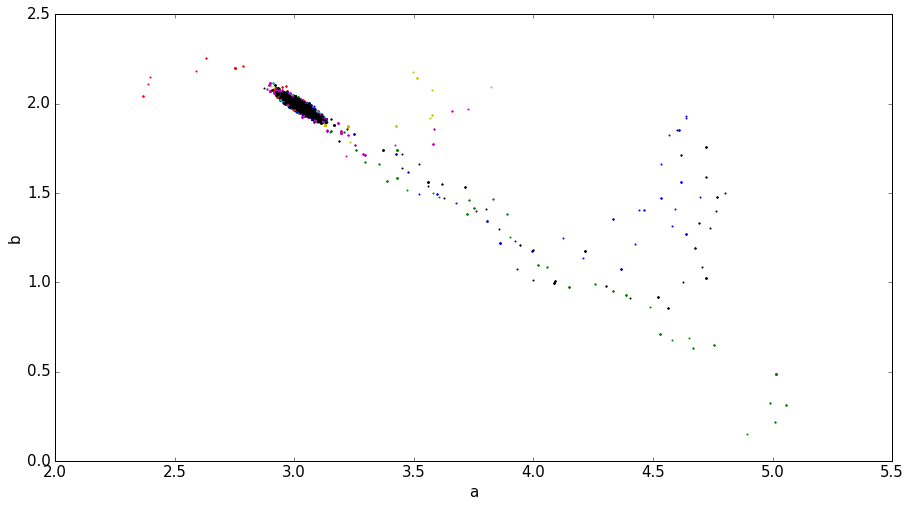

In [100]:
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size':15})
plt.scatter(x8, y8, color = 'w',s=1)
plt.scatter(x1, y1, color = 'g',s=1)
plt.scatter(x2, y2, color = 'r',s=1)
plt.scatter(x3, y3, color = 'y',s=1)
plt.scatter(x4, y4, color = 'b',s=1)
plt.scatter(x5, y5, color = 'c',s=1)
plt.scatter(x6, y6, color = 'm',s=1)
plt.scatter(x7, y7, color = 'k',s=1)
plt.xlabel('a')
plt.ylabel('b')


Se hace un histograma del numero de muestras para el parametro 'a'. Se hace un 'burning' de un tercio de las muestras.

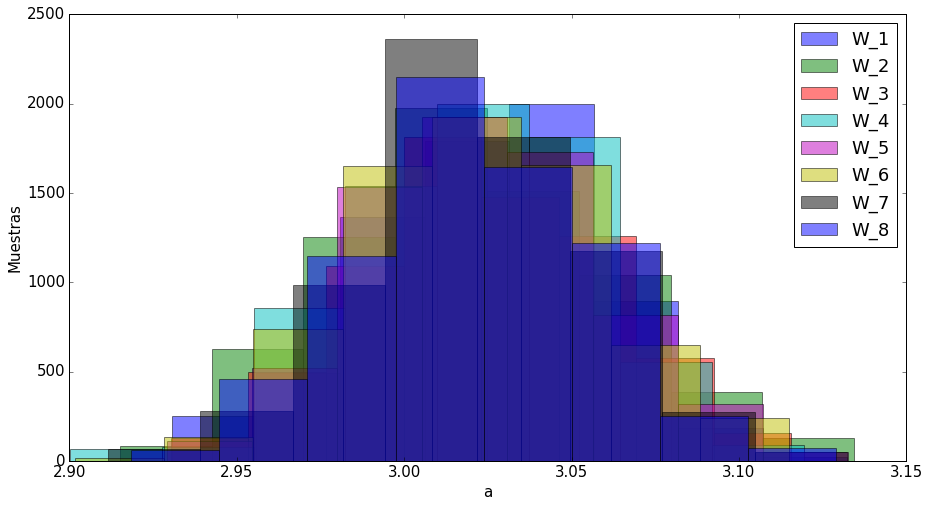

In [70]:
nb = 8
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size':15})
bur = 30
quemar(x1, bur)
plt.hist(quemar(x1, bur), alpha = 0.5, label = 'W_1', bins=nb)
plt.hist(quemar(x2, bur), alpha = 0.5, label = 'W_2', bins=nb)
plt.hist(quemar(x3, bur), alpha = 0.5, label = 'W_3', bins=nb)
plt.hist(quemar(x4, bur), alpha = 0.5, label = 'W_4', bins=nb)
plt.hist(quemar(x5, bur), alpha = 0.5, label = 'W_5', bins=nb)
plt.hist(quemar(x6, bur), alpha = 0.5, label = 'W_6', bins=nb)
plt.hist(quemar(x7, bur), alpha = 0.5, label = 'W_7', bins=nb)
plt.hist(quemar(x8, bur), alpha = 0.5, label = 'W_8', bins=nb)
plt.xlabel('a')
plt.ylabel('Muestras')
plt.legend()

Se hace un histograma del numero de muestras para el parametro 'b'. Se hace un 'burning' de un tercio de las muestras.

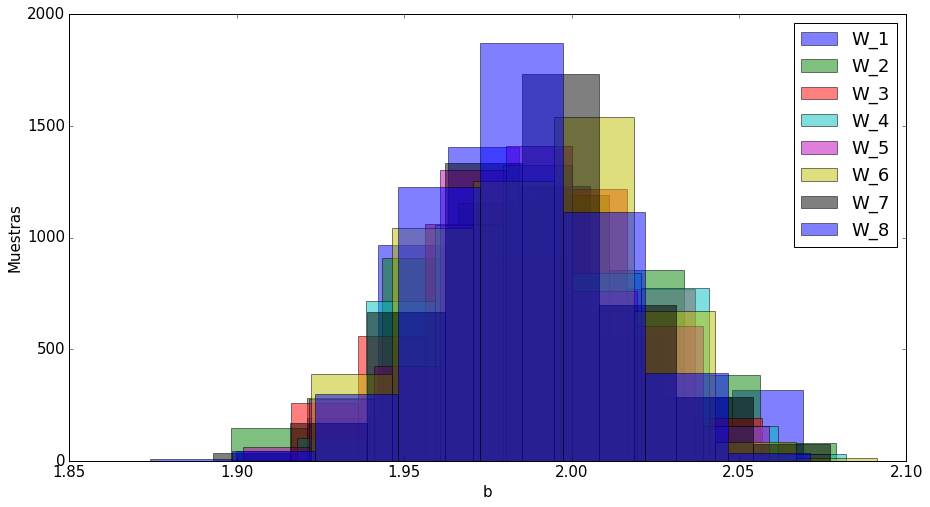

In [71]:
nb = 8
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size':15})
plt.hist(y1[int(Nmuestras/2):], alpha = 0.5, label = 'W_1', bins=nb)
plt.hist(y2[int(Nmuestras/2):], alpha = 0.5, label = 'W_2', bins=nb)
plt.hist(y3[int(Nmuestras/2):], alpha = 0.5, label = 'W_3', bins=nb)
plt.hist(y4[int(Nmuestras/2):], alpha = 0.5, label = 'W_4', bins=nb)
plt.hist(y5[int(Nmuestras/2):], alpha = 0.5, label = 'W_5', bins=nb)
plt.hist(y6[int(Nmuestras/2):], alpha = 0.5, label = 'W_6', bins=nb)
plt.hist(y7[int(Nmuestras/2):], alpha = 0.5, label = 'W_7', bins=nb)
plt.hist(y8[int(Nmuestras/2):], alpha = 0.5, label = 'W_8', bins=nb)
plt.xlabel('b')
plt.ylabel('Muestras')
plt.legend()

Se grafica un solo caminador para generar la grafica de esquina. Se hace un 'burning' de un tercio de las muestras.

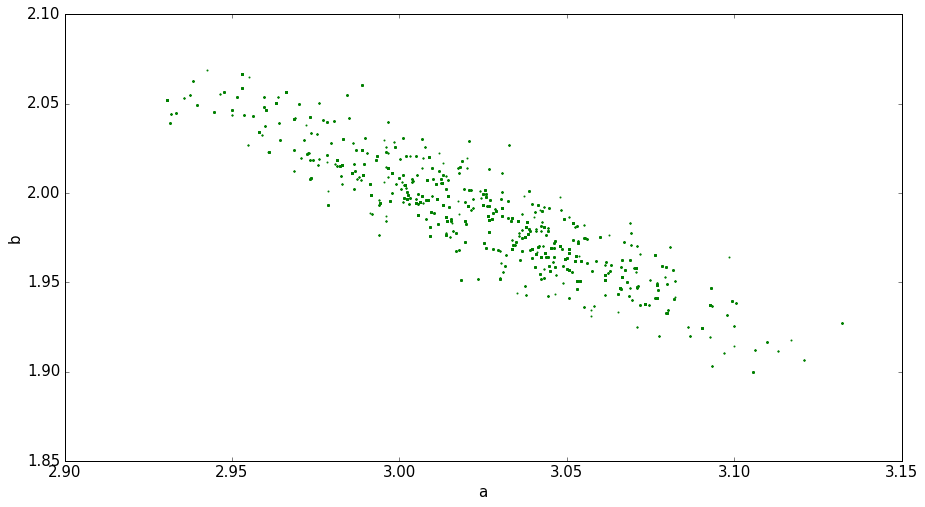

In [72]:
plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams.update({'font.size':15})
plt.xlabel('a')
plt.ylabel('b')
plt.scatter(x1[int(Nmuestras/3):], y1[int(Nmuestras/3):], color = 'g', s=1) # primer caminador

Se genera la grafica de esquina usando la libreria corner. Se hace un 'burning' de un tercio de las muestras.

/home/luiscantero/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


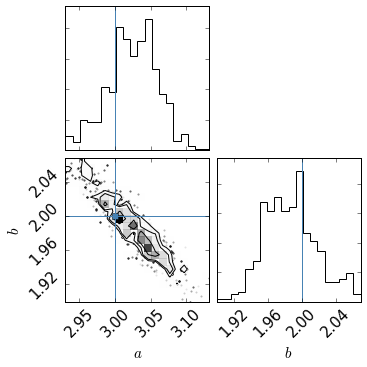

In [73]:
camino1 = np.array([x1[int(Nmuestras/3):], y1[int(Nmuestras/3):]])
fig = corner.corner(camino1.T,labels=["$a$", "$b$"], truths=[3, 2])
fig.show()

Se hace una grafica del numero de pasos - valor del parametro, se puede ver como los puntos se mueven alrededor de un valor definido. Se hace un 'burning' de un medio de las muestras.

Text(0,0.5,'a')

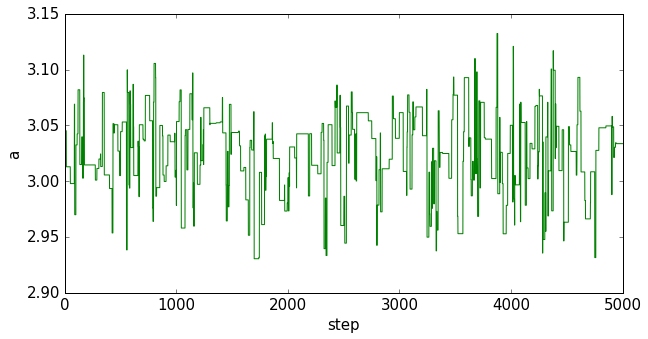

In [74]:
# Caminador 1
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size':15})
plt.plot(np.arange(len(x1[int(Nmuestras/2):])), x1[int(Nmuestras/2):], color = 'g')
plt.xlabel('step')
plt.ylabel('a')

Text(0,0.5,'b')

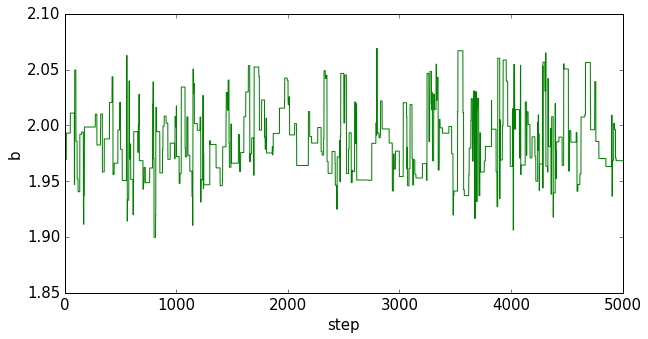

In [75]:
# Caminador 1
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size':15})
plt.plot(np.arange(len(x1[int(Nmuestras/2):])), y1[int(Nmuestras/2):], color = 'g')
plt.xlabel('step')
plt.ylabel('b')

Se hacen las mismas graficas para otra muestra

Text(0,0.5,'a')

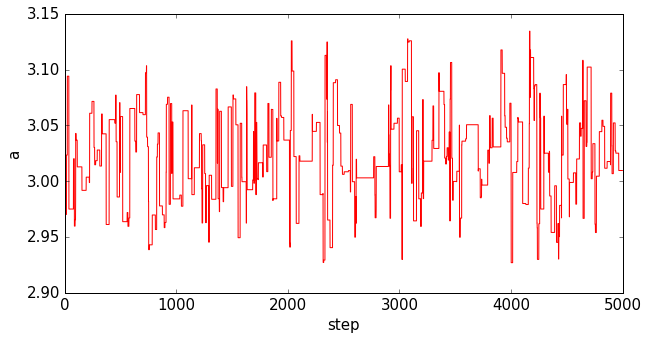

In [76]:
#Caminadr 2
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size':15})
plt.plot(np.arange(len(x2[int(Nmuestras/2):])), x2[int(Nmuestras/2):], color = 'r')
plt.xlabel('step')
plt.ylabel('a')

Text(0,0.5,'b')

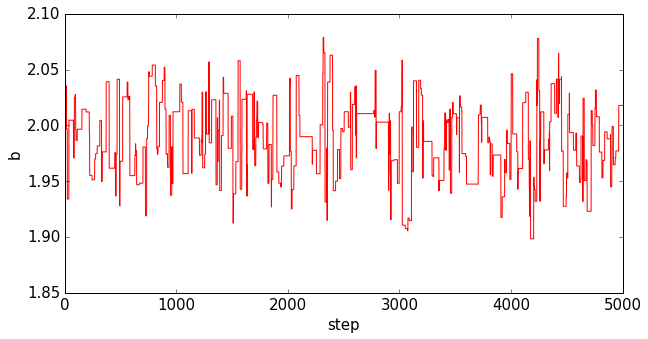

In [77]:
#Camindaor 2
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size':15})
plt.plot(np.arange(len(x2[int(Nmuestras/2):])), y2[int(Nmuestras/2):], color = 'r')
plt.xlabel('step')
plt.ylabel('b')

## Promedios de los resultados

### a

In [81]:
quemaymedia(x1, 30)

3.0237849520431848

In [82]:
quemaymedia(x2, 30)

3.020773594095302

In [83]:
quemaymedia(x3, 30)

3.023779460901823

In [84]:
quemaymedia(x4, 30)

3.021644647858286

In [85]:
quemaymedia(x5, 30)

3.0235570471734827

In [86]:
quemaymedia(x6, 30)

3.022466041199201

In [87]:
quemaymedia(x7, 30)

3.0220483080660614

In [88]:
quemaymedia(x8, 30)

3.0218403194081485

### b

In [90]:
quemaymedia(y1, 30)

1.9873513140355945

In [91]:
quemaymedia(y2, 30)

1.9887187260846346

In [92]:
quemaymedia(y3, 30)

1.9880096158848226

In [93]:
quemaymedia(y4, 30)

1.9893093675431015

In [94]:
quemaymedia(y5, 30)

1.9871227708700432

In [95]:
quemaymedia(y6, 30)

1.988786159842284

In [96]:
quemaymedia(y7, 30)

1.9879285527266273

#### Los valores promedios obtenidos son muy similares a los del modelo original, por lo tanto se obtuvo una buena aproximacion